In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [3]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
columns = ['rgnp','gdfim','ulc','pgnp','gdfco', 'gdf','gdfcf', 'gdfce']
df = df[columns]
df.head()

(123, 8)


,rgnp,gdfim,ulc,pgnp,gdfco,gdf,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,26.9,47.5,1608.3,36.9,37.4,32.3,23.1
1959-04-01,1637.0,27.0,47.5,1622.2,37.4,37.5,32.2,23.4
1959-07-01,1629.5,27.1,48.7,1636.2,37.6,37.6,32.4,23.4
1959-10-01,1643.4,27.1,48.8,1650.3,37.7,37.8,32.5,23.8
1960-01-01,1671.6,27.2,49.1,1664.6,37.8,37.8,32.4,23.8


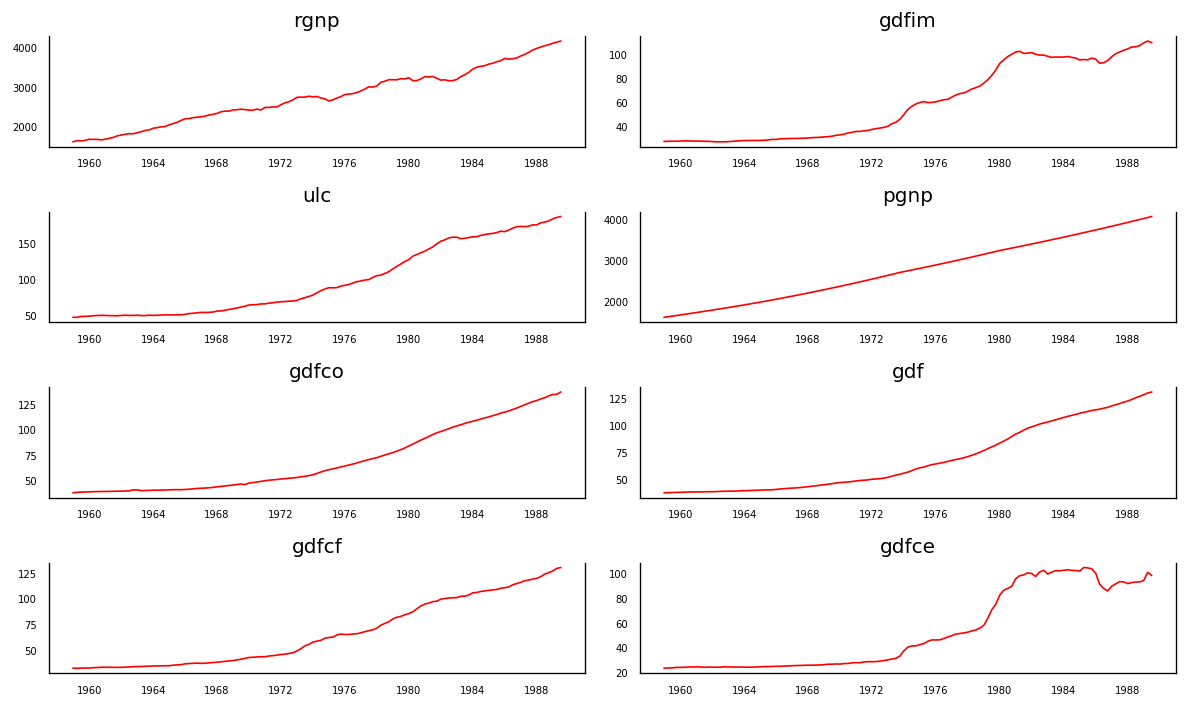

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Multivariate LSTM Forecast Model


#### LSTM Data Preparation

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
values = df.values
# ensure all data is float
values = values.astype('float32')

In [7]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(values)

In [8]:
# specify the number of lags
n_lags = 3
n_features = 8

# frame as supervised learning
data_reframed = series_to_supervised(data_scaled, n_lags, 1)
print(data_reframed.shape)

(120, 32)


In [9]:
data_reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.000000,0.003550,0.000000,0.000000,0.000000,0.000000,0.001024,0.000000,0.011970,0.004734,...,0.002047,0.003686,0.014473,0.005917,0.009292,0.017072,0.007976,0.004310,0.003071,0.008600
4,0.011970,0.004734,0.000000,0.005650,0.004985,0.001078,0.000000,0.003686,0.009036,0.005917,...,0.003071,0.008600,0.025504,0.007101,0.011437,0.022885,0.008973,0.004310,0.002047,0.008600
5,0.009036,0.005917,0.008578,0.011341,0.006979,0.002155,0.002047,0.003686,0.014473,0.005917,...,0.002047,0.008600,0.023626,0.009467,0.015011,0.028739,0.010967,0.006466,0.006141,0.009828
6,0.014473,0.005917,0.009292,0.017072,0.007976,0.004310,0.003071,0.008600,0.025504,0.007101,...,0.006141,0.009828,0.024252,0.009467,0.017870,0.034633,0.011964,0.007543,0.007165,0.012285
7,0.025504,0.007101,0.011437,0.022885,0.008973,0.004310,0.002047,0.008600,0.023626,0.009467,...,0.007165,0.012285,0.018658,0.007101,0.019300,0.040608,0.012961,0.008621,0.010235,0.013514


In [10]:
# split into train and test sets
values = data_reframed.values
n_train = 113
train = values[:n_train, :]
test = values[n_train:, :]

In [11]:
# split into input and outputs
n_obs = n_lags * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+1]
test_X, test_y = test[:, :n_obs], test[:, -n_features+1]
print(train_X.shape, len(train_X), train_y.shape)

(113, 24) 113 (113,)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lags, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lags, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(113, 3, 8) (113,) (7, 3, 8) (7,)


In [22]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=60, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 113 samples, validate on 7 samples
Epoch 1/100
 - 1s - loss: 0.5433 - val_loss: 1.3367
Epoch 2/100
 - 0s - loss: 0.5183 - val_loss: 1.2866
Epoch 3/100
 - 0s - loss: 0.4943 - val_loss: 1.2360
Epoch 4/100
 - 0s - loss: 0.4721 - val_loss: 1.1852
Epoch 5/100
 - 0s - loss: 0.4508 - val_loss: 1.1345
Epoch 6/100
 - 0s - loss: 0.4305 - val_loss: 1.0837
Epoch 7/100
 - 0s - loss: 0.4106 - val_loss: 1.0329
Epoch 8/100
 - 0s - loss: 0.3915 - val_loss: 0.9821
Epoch 9/100
 - 0s - loss: 0.3735 - val_loss: 0.9315
Epoch 10/100
 - 0s - loss: 0.3564 - val_loss: 0.8811
Epoch 11/100
 - 0s - loss: 0.3398 - val_loss: 0.8308
Epoch 12/100
 - 0s - loss: 0.3235 - val_loss: 0.7805
Epoch 13/100
 - 0s - loss: 0.3074 - val_loss: 0.7299
Epoch 14/100
 - 0s - loss: 0.2914 - val_loss: 0.6792
Epoch 15/100
 - 0s - loss: 0.2759 - val_loss: 0.6285
Epoch 16/100
 - 0s - loss: 0.2609 - val_loss: 0.5774
Epoch 17/100
 - 0s - loss: 0.2461 - val_loss: 0.5268
Epoch 18/100
 - 0s - loss: 0.2318 - val_loss: 0.4761
Epoch 19/10

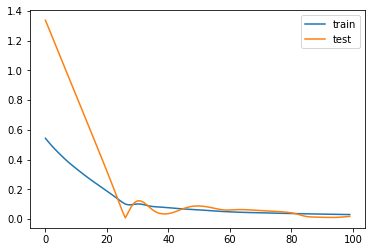

In [23]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_lags*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

inv_y = df['rgnp'].values[-7:]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

Test RMSE: 62.2336


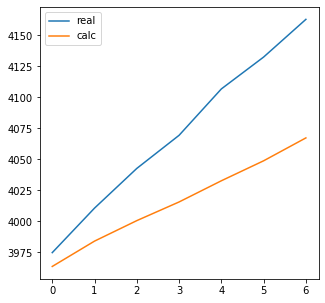

In [26]:
plt.figure(figsize=(5,5))
plt.plot(inv_y,label='real')
plt.plot(inv_yhat,label='calc')
plt.legend()
plt.show()